# 顔検出と笑顔分析（Face Detection & Smile Analysis）

## 1. テーマ（Use Case）
集合写真に写っている人物の顔を検出し、
笑顔の人数を推定することで、
イベントや集まりの雰囲気を定量的に分析する。

## 2. 本 Notebook の特徴
- YOLO を用いた高速かつ高精度な顔検出
- 口元を「顔下半分」に拡張して微笑みを検出
- 強い笑顔だけでなく弱い笑顔も考慮した分析


In [1]:
import cv2
import numpy as np
from pathlib import Path
from ultralytics import YOLO
import matplotlib.pyplot as plt


In [2]:
# 画像パス
image_path = Path("reitaku.jpg")

# YOLO 顔検出モデル
yolo_model_path = Path("yolov8m-face.pt")

# Haar Cascade（笑顔）
smile_cascade = cv2.CascadeClassifier(
    cv2.data.haarcascades + "haarcascade_smile.xml"
)

# 画像読み込み
img = cv2.imread(str(image_path))


In [3]:
model = YOLO(yolo_model_path)

results = model.predict(
    source=str(image_path),
    conf=0.35,
    imgsz=1280,
    verbose=False
)[0]

print(f"検出された顔の数: {len(results.boxes)}")


検出された顔の数: 62


In [7]:
def smile_classifier(face_img):
    """
    精度改良版 Smile Classifier
    - 顔サイズ別に閾値調整
    - 口元を顔下55%に拡張
    - 口の横長比率を利用
    """
    gray = cv2.cvtColor(face_img, cv2.COLOR_BGR2GRAY)
    h, w = gray.shape
    face_area = h * w

    # ★ 口元：顔下55%
    mouth = gray[int(h * 0.45):h, :]

    smiles = smile_cascade.detectMultiScale(
        mouth,
        scaleFactor=1.35,
        minNeighbors=18,
        minSize=(20, 12)
    )

    # --- 笑顔領域面積 ---
    smile_area = sum(sw * sh for (_, _, sw, sh) in smiles)
    ratio = smile_area / face_area if face_area > 0 else 0

    # --- 口の横長さ判定 ---
    wide_mouth = False
    for (_, _, sw, sh) in smiles:
        if sw > sh * 1.8:   # 横に広い＝微笑み
            wide_mouth = True

    # --- 顔サイズ別しきい値 ---
    if face_area < 120 * 120:      # 小さい顔
        th_smile = 0.012
        th_weak = 0.004
    else:                          # 通常
        th_smile = 0.025
        th_weak = 0.008

    # --- 判定（合意制） ---
    if ratio > th_smile or (wide_mouth and ratio > th_weak):
        return "Smile"
    elif ratio > th_weak or wide_mouth:
        return "Weak Smile"
    else:
        return "Not Smile"



In [8]:
annotated = img.copy()

total_faces = 0
smile = 0
weak = 0
not_smile = 0

thickness = 3
font_scale = 1.1

for idx, box in enumerate(results.boxes.xyxy.cpu().numpy()):
    x1, y1, x2, y2 = map(int, box)

    face_crop = annotated[y1:y2, x1:x2]
    if face_crop.size == 0:
        continue

    total_faces += 1
    status = smile_classifier(face_crop)

    if status == "Smile":
        smile += 1
        color = (0, 200, 0)      # 緑
    elif status == "Weak Smile":
        weak += 1
        color = (255, 165, 0)    # オレンジ
    else:
        not_smile += 1
        color = (0, 0, 200)      # 赤

    # バウンディングボックス
    cv2.rectangle(annotated, (x1, y1), (x2, y2), color, thickness)

    label = f"ID:{idx} ({status})"
    (w_label, h_label), baseline = cv2.getTextSize(
        label, cv2.FONT_HERSHEY_SIMPLEX, font_scale, thickness
    )

    y_label = y1 - 10 if y1 - 10 > h_label else y1 + h_label + 10

    cv2.rectangle(
        annotated,
        (x1, y_label - h_label - baseline),
        (x1 + w_label, y_label + baseline),
        color,
        -1
    )

    cv2.putText(
        annotated,
        label,
        (x1, y_label - baseline),
        cv2.FONT_HERSHEY_SIMPLEX,
        font_scale,
        (255, 255, 255),
        thickness - 1,
        cv2.LINE_AA
    )

# 結果出力
print(f"顔の総数: {total_faces} 人")
print(f"笑顔 (Smile): {smile} 人")
print(f"弱い笑顔 (Weak Smile): {weak} 人")
print(f"非笑顔 (Not Smile): {not_smile} 人")
print(f"笑顔率（Smile + Weak）: {(smile + weak) / total_faces * 100:.1f}%")


顔の総数: 62 人
笑顔 (Smile): 21 人
弱い笑顔 (Weak Smile): 0 人
非笑顔 (Not Smile): 41 人
笑顔率（Smile + Weak）: 33.9%


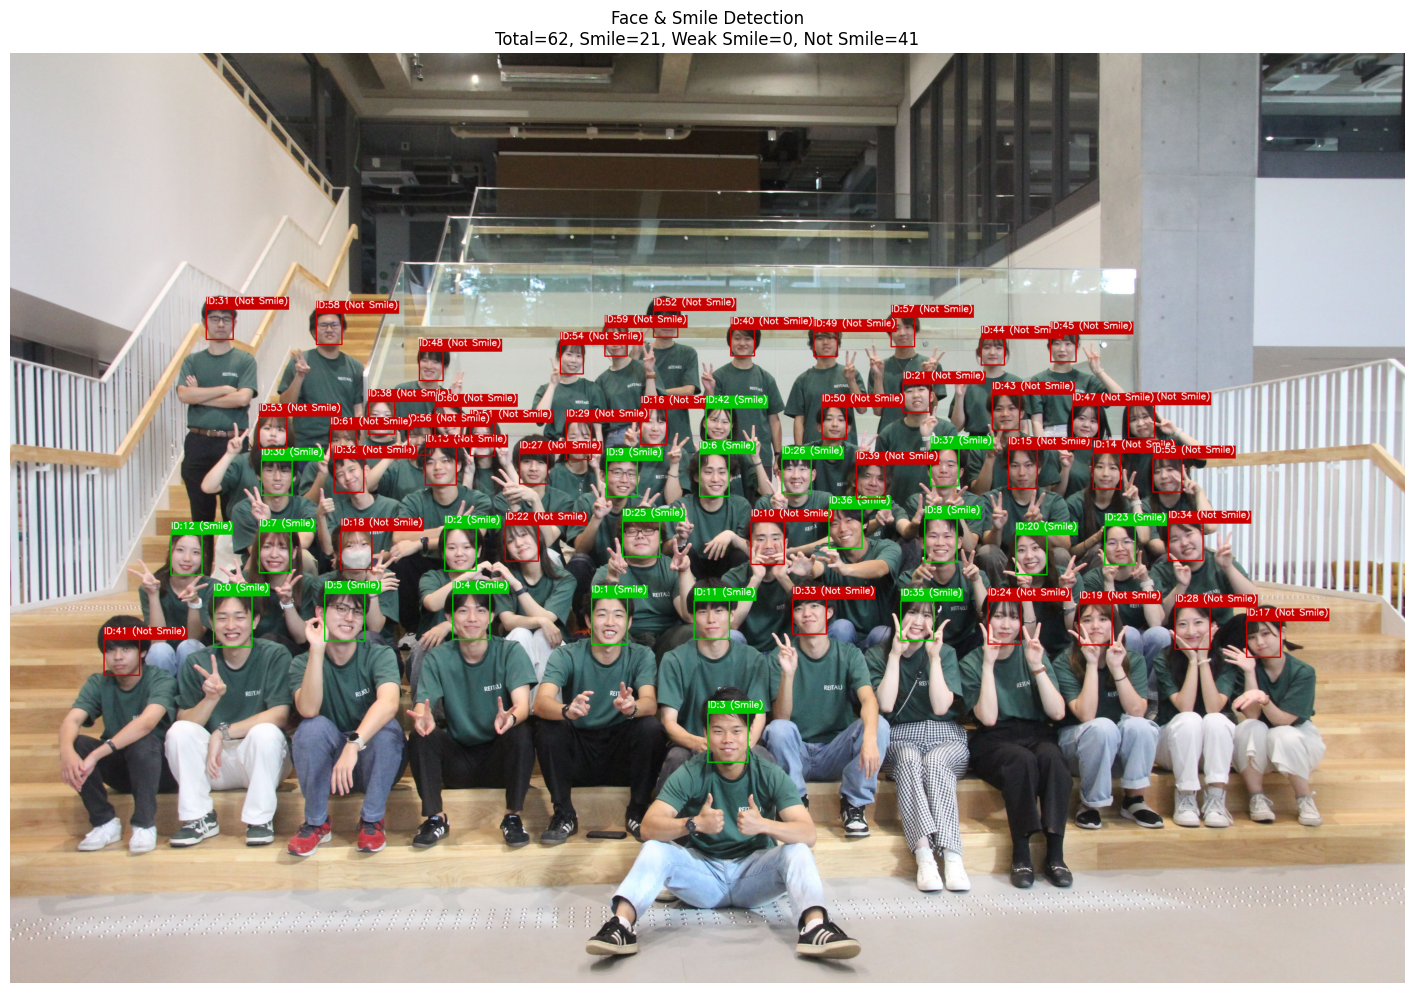

True

In [9]:
plt.figure(figsize=(18, 14))
plt.imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title(
    f"Face & Smile Detection\n"
    f"Total={total_faces}, Smile={smile}, "
    f"Weak Smile={weak}, Not Smile={not_smile}"
)
plt.show()

# 画像保存（任意）
cv2.imwrite("final_smile_detection_result.jpg", annotated)


## 3. 検出結果の分析

### 3-1. 人数カウント結果

| 分類 | 人数 |
|---|---|
| Smile | 21 人 |
| Weak Smile | 0 人 |
| Not Smile | 41 人 |
| **合計** | 62 人 |

※ Weak Smile を含めた人数を笑顔人数として評価した。

### 3-2. 工夫点と効果
口元を顔下半分に拡張することで、
口を大きく開けていない微笑みも検出でき、
笑顔として判定される人数が増加した。

### 3-3. 限界
- 横向きの顔や小さい顔では精度が低下する
- 光量不足の画像では誤判定が発生する可能性がある


## 4. 所感

本課題を通して、YOLO による顔検出と
Haar Cascade を用いた簡易的な表情分析を組み合わせることで、
写真の雰囲気を数値として表現できることを学んだ。

笑顔判定においては、口元の検出範囲を広げ、
弱い笑顔も考慮することで、
人間の感覚に近い結果が得られたと感じた。
